# Observed data along trajectories 

- Data from ERA-INTERIM and from GIMMS.
- Specific humidity and moisture flux.
- Multiple trajectories using `cdlearn.trajectories.StaticTrajectory` class. All of them begin at the same initial position.
- Get observed data of water vapour content, NDVI, total precipitation, evaporation along all trajectories.
- Save these trajectories inside individual `.csv` files (**time consuming operation**).

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import os
import sys
import glob
import calendar

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__)
print(">>> Version of pandas:", pd.__version__)

>>> Version of xarray: 0.14.0
>>> Version of pandas: 0.24.2


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20 # Latitude in ascending order.

# Time range. 
ti, tf = "1981-07", "2012-09"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Main folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/"

# Moisture transport data folder.
MOISTURE_FOLDER = DATA_FOLDER + "ERA_INTERIM/moisture_transport_mmeans/"

# NDVI data folder.
VEGETATION_FOLDER = DATA_FOLDER + "GIMMS/NDVI_mmeans/"

# Total precipitation data folder.
PRECIPITATION_FOLDER = DATA_FOLDER + "ERA_INTERIM/total_precipitation_mmeans/"

# Evaporation data folder.
EVAPORATION_FOLDER = DATA_FOLDER + "ERA_INTERIM/evaporation_mmeans/"

# Where put results for trajectories.
TRAJECTORIES_FOLDER = DATA_FOLDER + "TRAJECTORIES/ensemble1/"

## 2 Load and preprocess data

### 2.1 Moisture transport

In [7]:
# List files.
MOISTURE_FILES = sorted(glob.glob(MOISTURE_FOLDER + "*.grb"))

In [8]:
%%time

# DataSets objects.
DS_mt = xr.open_mfdataset(MOISTURE_FILES, engine="cfgrib", concat_dim="time")

CPU times: user 1min 9s, sys: 603 ms, total: 1min 9s
Wall time: 1min 10s


In [9]:
%%time

# Shift longitudes and guarantee time ordering. 
# Latitude is also put in ascending order.
DS_mt = DS_mt.assign_coords(longitude=(DS_mt.longitude + 180) % 360 - 180)
DS_mt = DS_mt.sortby(DS_mt.latitude)
DS_mt = DS_mt.sortby(DS_mt.longitude)
DS_mt = DS_mt.sortby(DS_mt.time)

CPU times: user 158 ms, sys: 4 ms, total: 162 ms
Wall time: 158 ms


In [10]:
# South America at commom time range.
DS_mt = DS_mt.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [11]:
%%time

# Let's rename some variables.
DS_mt = DS_mt.rename(
    name_dict={"v": "w", 
               "q": "Uwind",     
               "sp": "Vwind", 
               "stl1": "Fx", 
               "swl1": "Fy"}
)

# Names and units for variables.
long_names = [
    "specific humidity [kg/m2]", 
    "zonal wind [kg/m/s]",
    "meridional wind [kg/m/s]",
    "zonal moisture flux [kg/m/s]",
    "meridional moisture flux [kg/m/s]"
]

# Put them as attributes.
for var_name, long_name in zip(DS_mt.data_vars.keys(), long_names):
    DS_mt[var_name].attrs = {}
    DS_mt[var_name].attrs["long_name"] = long_name

CPU times: user 1.27 ms, sys: 14 µs, total: 1.28 ms
Wall time: 1.28 ms


**I have some doubts about units.**

In [12]:
# Calculate velocities of air masses.
DS_mt = DS_mt.assign(u = DS_mt.Fx / DS_mt.w, v = DS_mt.Fy / DS_mt.w)

In [13]:
# Load into memory.
with ProgressBar():
    DS_mt = DS_mt.compute()

[########################################] | 100% Completed | 29.5s


In [14]:
# Put land-sea mask.
DS_mt = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_mt)

### 2.2 NDVI

In [19]:
# List files.
VEGETATION_FILES = sorted(glob.glob(VEGETATION_FOLDER + "*.nc4"))

In [20]:
%%time

# Lazy read of global data sets.
DS_ndvi = xr.open_mfdataset(VEGETATION_FILES, concat_dim="time")

# Latitude in ascending order.
DS_ndvi = DS_ndvi.sortby(DS_ndvi.latitude)

CPU times: user 452 ms, sys: 32.2 ms, total: 484 ms
Wall time: 511 ms


In [21]:
# South America at commom time range.
DS_ndvi = DS_ndvi.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [22]:
# Load into memory.
with ProgressBar():
    DS_ndvi = DS_ndvi.compute()

[########################################] | 100% Completed |  0.7s


In [23]:
# Put mask.
DS_ndvi = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_ndvi)

### 2.3 Total precipitation

In [24]:
# List files.
PRECIPITATION_FILES = sorted(glob.glob(PRECIPITATION_FOLDER + "*.grb"))

In [25]:
%%time

# DataSets objects.
DS_tp = xr.open_mfdataset(PRECIPITATION_FILES, engine="cfgrib", concat_dim="time")

CPU times: user 1.84 s, sys: 20.3 ms, total: 1.86 s
Wall time: 1.88 s


In [26]:
%%time

# Shift longitudes and guarantee time ordering.
# Latitude is also put in ascending order.
DS_tp = DS_tp.assign_coords(longitude=(DS_tp.longitude + 180) % 360 - 180)
DS_tp = DS_tp.sortby(DS_tp.latitude)
DS_tp = DS_tp.sortby(DS_tp.longitude)
DS_tp = DS_tp.sortby(DS_tp.time)

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 14.7 ms


In [27]:
# South America at commom time range.
DS_tp = DS_tp.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [28]:
# Load into memory.
with ProgressBar():
    DS_tp = DS_tp.compute()

[########################################] | 100% Completed |  4.5s


In [29]:
# Put land-sea mask.
DS_tp = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_tp)

### 2.4 Evaporation

In [30]:
# List files.
EVAPORATION_FILES = sorted(glob.glob(EVAPORATION_FOLDER + "*.grb"))

In [31]:
%%time

# DataSets object.
DS_e = xr.open_mfdataset(EVAPORATION_FILES, engine="cfgrib", concat_dim="time")

CPU times: user 1.64 s, sys: 20 ms, total: 1.66 s
Wall time: 1.68 s


In [32]:
%%time

# Shift longitudes and guarantee time ordering.
# Latitude is also put in ascending order.
DS_e = DS_e.assign_coords(longitude=(DS_e.longitude + 180) % 360 - 180)
DS_e = DS_e.sortby(DS_e.latitude)
DS_e = DS_e.sortby(DS_e.longitude)
DS_e = DS_e.sortby(DS_e.time)

CPU times: user 17.9 ms, sys: 0 ns, total: 17.9 ms
Wall time: 20.7 ms


In [33]:
# South America at commom time range.
DS_e = DS_e.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [34]:
# Load into memory.
with ProgressBar():
    DS_e = DS_e.compute()

[########################################] | 100% Completed |  6.3s


In [35]:
# Put land-sea mask.
DS_e = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_e)

## 3 Data distributions

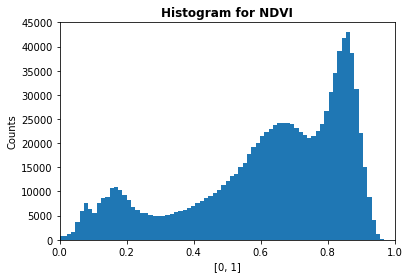

In [36]:
# Histogram for NDVI.
plt.hist(DS_ndvi.ndvi.values.flatten(), bins=100);
plt.xlim((0, 1))
plt.ylim((0, 45000))
plt.title("Histogram for NDVI", weight="bold")
plt.xlabel("[0, 1]")
plt.ylabel("Counts");

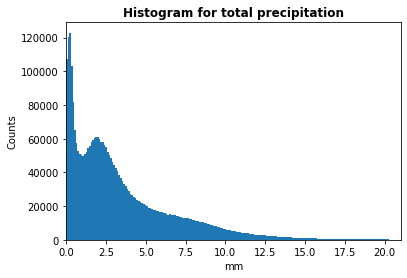

In [37]:
# Histogram for total precipitation.
plt.hist(1000 * DS_tp.tp.values.flatten(), bins=1000);
plt.xlim((0, 21))
plt.title("Histogram for total precipitation", weight="bold")
plt.xlabel("mm")
plt.ylabel("Counts");

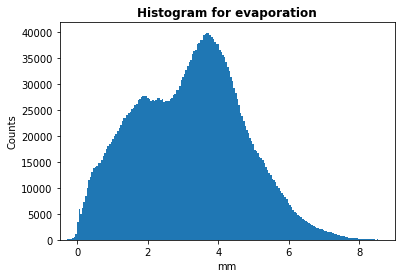

In [38]:
# Histogram for evaporation.
plt.hist(-1000 * DS_e.e.values.flatten(), bins=250);
plt.xlim((-0.5, 9))
plt.title("Histogram for evaporation", weight="bold")
plt.xlabel("mm")
plt.ylabel("Counts");

## 4 Trajectories

### 4.1 Generate ensemble of trajectories using `cdlearn.trajectories.StaticTrajectory`.

Generate all trajectories and save each one in a `.csv` file.

In [39]:
%%time

# Initial position.
p0 = np.array([0, -35]) # This is very good initial position! Keep it!

# Time integration parameters.
dt = 2500        # Time step.
T = 25*24*60*60  # 25 days.

# Sanity check.
DS_mt["time"], DS_ndvi["time"], DS_tp["time"], DS_e["time"] = \
    xr.align(DS_mt.time, DS_ndvi.time, DS_tp.time, DS_e.time, join="inner")

# Time index.
DS_ti = DS_mt.time

# Months.
months = np.unique(DS_ti.dt.month).tolist()

# Sazonal loop.
for month in months:

    month_str = calendar.month_name[month]    
    print(">>> Processing", month_str, "...")
    
    # The same month across years.
    time_mask = DS_ti.time.dt.month == month
    time0s = pd.to_datetime(
        DS_ti.time.sel(time=DS_ti.time[time_mask]).values
    )
    
    # Loop over years at the same month.
    for time0 in time0s:
        
        # Scalar and vectorial data.
        U=DS_mt.u.sel(time=time0, method="nearest")
        V=DS_mt.v.sel(time=time0, method="nearest")
        
        # Initialize trajectory.
        st = cdlearn.trajectories.StaticTrajectory(
            U=U, 
            V=V, 
            angular_position0=p0, 
            time0=time0
        )

        # Run trajectory.
        df_trajectory = st.run(dt=dt, T=T)
        
        # Water vapour content along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DS_mt.w.sel(time=time0).where(DS_mt.land_mask==True),
            var_name="w"
        )
                
        # NDVI data along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DS_ndvi.ndvi.sel(time=time0).where(DS_ndvi.land_mask==True),
            var_name="ndvi"
        )
        
        # Total precipitation data along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DS_tp.tp.sel(time=time0).where(DS_tp.land_mask==True),
            var_name="tp"
        )        
        
        # Evaporation data along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DS_e.e.sel(time=time0).where(DS_e.land_mask==True),
            var_name="e"
        )        
        
        # Save trajectories.
        pos0_str = "pos0_" + str("%05.2f_%05.2f" %(p0[0], p0[1]))
        date0_str = "_date0_" + str(time0.year) + str("_%02d" %month) 
        file_name = pos0_str + date0_str + ".csv"
        df_trajectory.to_csv(path_or_buf=TRAJECTORIES_FOLDER + file_name)

>>> Processing January ...
>>> Processing February ...
>>> Processing March ...
>>> Processing April ...
>>> Processing May ...
>>> Processing June ...
>>> Processing July ...
>>> Processing August ...
>>> Processing September ...
>>> Processing October ...
>>> Processing November ...
>>> Processing December ...
CPU times: user 56min 56s, sys: 28.3 s, total: 57min 24s
Wall time: 58min 52s
